----------------------------------------------------------
## 머신러닝을 활용한 선거조사(전화조사) 무응답 보정
----------------------------------------------------------
- ID : 응답자 구별코드
- SIDO : 시도 구분
- AREA : 권역별
- SEX  : 성별
- AGE1 : 연령(숫자)
- AGE  : 연령대
- Q1   : 대통령 지지 후보(재질문 통합)  <-- target
- Q2   : 지지 후보 결정 시기
- Q3   : 지지 후보 선택 이유
- Q4   : 정당 지지도(재질문 통합)
- DQ1  : 정치적 이념성향
- DQ2  : 과거 대선 지지
- DQ3  : 과거 총선 정당 지지
- DQ4  : 직업
- DQ5  : 소득
- WT   : 인구통계학적 가중치
----------------------------------------------------------

In [ ]:
#############################################################################################
## 코랩 한글깨짐 해결
#############################################################################################
##1) 나눔폰트 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

# #2) 런타임 재시작

#3) matplotlib의 폰트를 Nanum 폰트로 지정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
#############################################################################################
## 데이터 불러오기
#############################################################################################

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/content/drive/MyDrive/_project/전화조사데이터_WT.xlsx')


# ## 지지후보 응답데이터 : 2757
# df1 = df[df.TYPE == 1]

# ## 지지후보 없음/무응답데이터 : 329
# df2 = df[df.TYPE == 2]



In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3086 entries, 0 to 3085
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3086 non-null   int64  
 1   SIDO    3086 non-null   int64  
 2   AREA    3086 non-null   int64  
 3   SEX     3086 non-null   int64  
 4   AGE1    3086 non-null   int64  
 5   AGE     3086 non-null   int64  
 6   Q1      2757 non-null   float64
 7   Q2      2757 non-null   float64
 8   Q3      2757 non-null   float64
 9   Q4      3086 non-null   int64  
 10  DQ1     3086 non-null   int64  
 11  DQ2     3086 non-null   int64  
 12  DQ3     3086 non-null   int64  
 13  DQ4     3086 non-null   int64  
 14  DQ5     3086 non-null   int64  
 15  WT      3086 non-null   float64
 16  TYPE    3086 non-null   int64  
dtypes: float64(4), int64(13)
memory usage: 410.0 KB


,ID,SIDO,AREA,SEX,AGE1,AGE,Q1,Q2,Q3,Q4,DQ1,DQ2,DQ3,DQ4,DQ5,WT,TYPE
0,1,8,2,2,55,4,3.0,3.0,4.0,3,3,1,2,9,2,1.411765,1
1,2,1,1,2,40,3,1.0,6.0,1.0,1,3,2,2,6,3,1.333333,1
2,3,8,2,1,68,5,3.0,6.0,1.0,3,1,1,3,5,1,0.611111,1
3,4,1,1,2,66,5,NaN,NaN,NaN,4,9,1,1,5,1,1.351351,2
4,5,2,6,2,46,3,1.0,6.0,2.0,1,3,2,2,6,2,1.555556,1


In [ ]:
#######################################################################################
## 데이터 결측치, 이상치 확인
#######################################################################################

## 결측치 확인
df.isna().sum()

ID        0
SIDO      0
AREA      0
SEX       0
AGE1      0
AGE       0
Q1      329
Q2      329
Q3      329
Q4        0
DQ1       0
DQ2       0
DQ3       0
DQ4       0
DQ5       0
WT        0
TYPE      0
dtype: int64

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


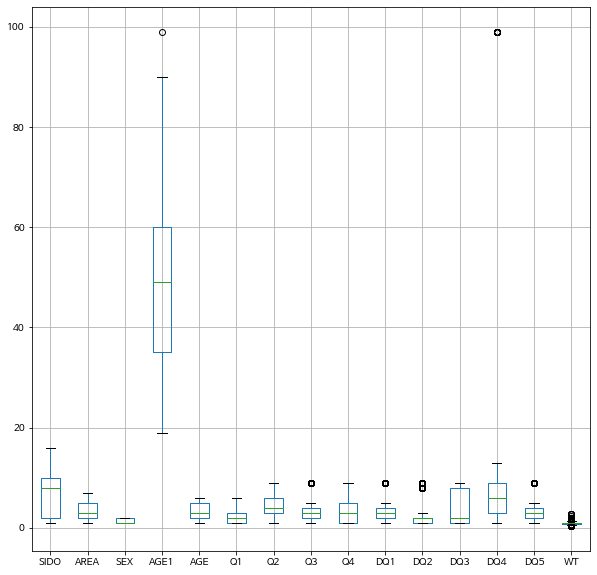

In [ ]:
## 지지후보 응답데이터에서  이상치 확인
df1 = df.drop(columns = ['ID'])

data1 = df1.iloc[:,:-1]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
data1.boxplot(ax=ax)


In [ ]:
## DQ4(직업) 변수에서 극단치 있음
df['DQ4'].value_counts()

9     661
6     652
2     544
10    235
3     189
12    181
8     155
4     131
5     107
1      84
11     64
7      45
13     24
99     14
Name: DQ4, dtype: int64

In [ ]:
## 99 '모르겠다' 값이 14개 있는데, 사례수도 적고, 모델에서는 극단치로 인식할것 같아 13 '기타'로 데이터 수정
df.loc[(df.DQ4==99),'DQ4']=13
df['DQ4'].value_counts()

9     661
6     652
2     544
10    235
3     189
12    181
8     155
4     131
5     107
1      84
11     64
7      45
13     38
Name: DQ4, dtype: int64

In [ ]:
#######################################################################################
## 추가변수 생성
#######################################################################################
 
## 성(SEX) & 연령(AGE) 으로 성연령(BSEXAGE) 변수 생성
df.loc[(df.SEX==1) & (df.AGE==1),'BSEXAGE']=1     #1.남-20대
df.loc[(df.SEX==1) & (df.AGE==2),'BSEXAGE']=2     #2.남-30대
df.loc[(df.SEX==1) & (df.AGE==3),'BSEXAGE']=3     #3.남-40대
df.loc[(df.SEX==1) & (df.AGE==4),'BSEXAGE']=4     #4.남-50대
df.loc[(df.SEX==1) & (df.AGE==5),'BSEXAGE']=5     #5.남-60대
df.loc[(df.SEX==1) & (df.AGE==6),'BSEXAGE']=6     #6.남-70대 이상

df.loc[(df.SEX==2) & (df.AGE==1),'BSEXAGE']=7     #7.여-20대
df.loc[(df.SEX==2) & (df.AGE==2),'BSEXAGE']=8     #8.여-30대
df.loc[(df.SEX==2) & (df.AGE==3),'BSEXAGE']=9     #9.여-40대
df.loc[(df.SEX==2) & (df.AGE==4),'BSEXAGE']=10    #10.여-50대
df.loc[(df.SEX==2) & (df.AGE==5),'BSEXAGE']=11    #11.여-60대
df.loc[(df.SEX==2) & (df.AGE==6),'BSEXAGE']=12    #12.여-70대 이상


## DQ1(정치이념성향) 세부적인 분류를 묶어서 변수 생성
df.loc[(df.DQ1==1) | (df.DQ1==2),'BDQ1']=1   #1.보수
df.loc[(df.DQ1==3),'BDQ1']=2                 #2.중도
df.loc[(df.DQ1==4) | (df.DQ1==5),'BDQ1']=3   #3.진보
df.loc[(df.DQ1==9),'BDQ1']=4                 #4.모름


## DQ4(직업) 세부적인 분류를 묶어서 변수 생성
df.loc[(df.DQ4==1),'BDQ4']=1                                   #1.농/임/어업
df.loc[(df.DQ4==2),'BDQ4']=2                                   #2.자영업
df.loc[(df.DQ4==3) | (df.DQ4==4) | (df.DQ4==5),'BDQ4']=3       #3.블루칼라
df.loc[(df.DQ4==6) | (df.DQ4==7) | (df.DQ4==8),'BDQ4']=4       #4.화이트칼라
df.loc[(df.DQ4==9),'BDQ4']=5                                   #5.가정주부
df.loc[(df.DQ4==10),'BDQ4']=6                                  #6.학생
df.loc[(df.DQ4==11) | (df.DQ4==12) | (df.DQ4==13),'BDQ4']=7    #7.무직/은퇴/기타
df.loc[(df.DQ4==99),'BDQ4']=8                                  #8.모름


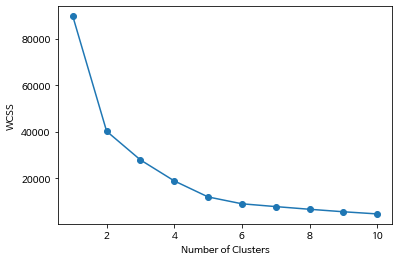

In [ ]:
## K-mean 생성변수 (변수중요도에서 높게 나온 'Q4', 'SIDO' 시도함)
from sklearn.cluster import KMeans
from scipy.stats import norm, boxcox
from scipy import stats

clus = df[['Q4', 'SIDO']].values

def elbow():
  wcss = []
  for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(clus)
    wcss.append(kmeans.inertia_)

  fig = plt.figure()
  ax = fig.add_subplot(111, xlabel="Number of Clusters", ylabel="WCSS")
  plt.plot(range(1,11), wcss, marker='o')
  plt.show()

elbow()


In [ ]:
## 클러스터 5개로 선택
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
Y = kmeans.fit_predict(clus)

print(Y)
print(np.unique(Y))

[1 0 1 ... 5 3 0]
[0 1 2 3 4 5]


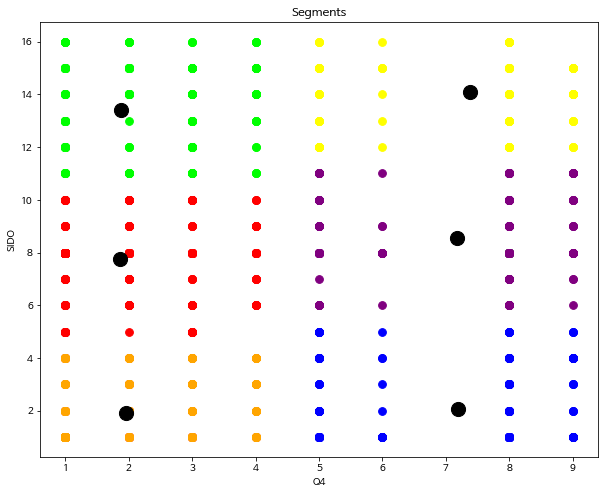

In [ ]:
## 클러스터 그래프 확인
plt.figure(figsize=(10,8))
plt.scatter(clus[Y==0,0], clus[Y==0,1], s=60, c='orange', label='Cluster 1')
plt.scatter(clus[Y==1,0], clus[Y==1,1], s=60, c='red', label='Cluster 2')
plt.scatter(clus[Y==2,0], clus[Y==2,1], s=60, c='purple', label='Cluster 3')
plt.scatter(clus[Y==3,0], clus[Y==3,1], s=60, c='lime', label='Cluster 4')
plt.scatter(clus[Y==4,0], clus[Y==4,1], s=60, c='blue', label='Cluster 5')
plt.scatter(clus[Y==5,0], clus[Y==5,1], s=60, c='yellow', label='Cluster 6')

# plot the centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c='black')

plt.title('Segments')
plt.xlabel('Q4')
plt.ylabel('SIDO')
plt.show()

In [ ]:
## 세그먼트 추가변수생성
# segment 1
df.loc[(df.SIDO==1) & (df.Q4==1),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==1),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==1),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==1),'SEG']=1

df.loc[(df.SIDO==1) & (df.Q4==2),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==2),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==2),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==2),'SEG']=1

df.loc[(df.SIDO==1) & (df.Q4==3),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==3),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==3),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==3),'SEG']=1

df.loc[(df.SIDO==1) & (df.Q4==4),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==4),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==4),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==4),'SEG']=1

# segment 2
df.loc[(df.SIDO==5) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==1),'SEG']=2

df.loc[(df.SIDO==5) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==2),'SEG']=2

df.loc[(df.SIDO==5) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==3),'SEG']=2

df.loc[(df.SIDO==5) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==4),'SEG']=2

# segment 3
df.loc[(df.SIDO==11) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==1),'SEG']=3

df.loc[(df.SIDO==11) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==2),'SEG']=3

df.loc[(df.SIDO==11) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==3),'SEG']=3

df.loc[(df.SIDO==11) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==4),'SEG']=3

# segment 4
df.loc[(df.SIDO==1) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==5),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==6),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==7),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==8),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==9),'SEG']=4

# segment 5
df.loc[(df.SIDO==6) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==5),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==6),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==7),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==8),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==8),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==9),'SEG']=5

# segment 6
df.loc[(df.SIDO==12) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==5),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==6),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==7),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==8),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==9),'SEG']=6

df.isna().sum()


ID           0
SIDO         0
AREA         0
SEX          0
AGE1         0
AGE          0
Q1         329
Q2         329
Q3         329
Q4           0
DQ1          0
DQ2          0
DQ3          0
DQ4          0
DQ5          0
WT           0
TYPE         0
BSEXAGE      0
BDQ1         0
BDQ4         0
SEG          0
dtype: int64

In [ ]:
df.to_excel('/content/drive/MyDrive/_project/df.xlsx')
df.head()

,ID,SIDO,AREA,SEX,AGE1,AGE,Q1,Q2,Q3,Q4,DQ1,DQ2,DQ3,DQ4,DQ5,WT,TYPE,BSEXAGE,BDQ1,BDQ4,SEG
0,1,8,2,2,55,4,3.0,3.0,4.0,3,3,1,2,9,2,1.411765,1,10.0,2.0,5.0,2.0
1,2,1,1,2,40,3,1.0,6.0,1.0,1,3,2,2,6,3,1.333333,1,9.0,2.0,4.0,1.0
2,3,8,2,1,68,5,3.0,6.0,1.0,3,1,1,3,5,1,0.611111,1,5.0,1.0,3.0,2.0
3,4,1,1,2,66,5,NaN,NaN,NaN,4,9,1,1,5,1,1.351351,2,11.0,4.0,3.0,1.0
4,5,2,6,2,46,3,1.0,6.0,2.0,1,3,2,2,6,2,1.555556,1,9.0,2.0,4.0,1.0


In [ ]:
#######################################################################################
## 데이터 그래프로 확인
#######################################################################################

## 후보별 지지자 데이터 생성
df_1 = df[df.Q1 == 1]   #문재인
df_2 = df[df.Q1 == 2]   #홍준표
df_3 = df[df.Q1 == 3]   #안철수

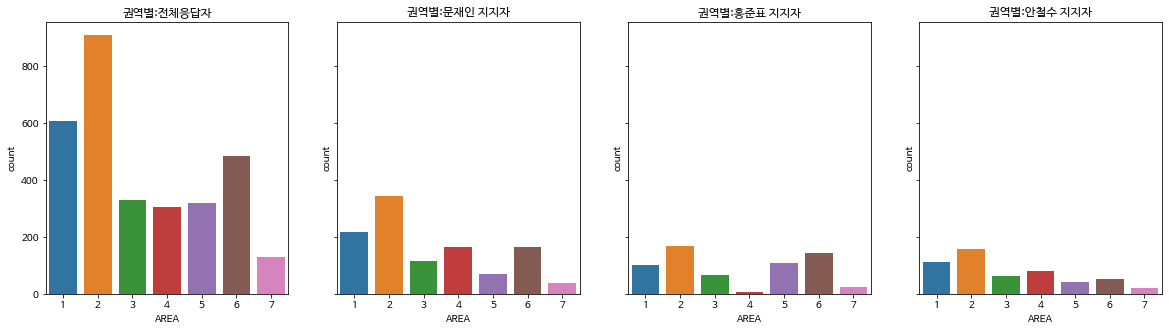

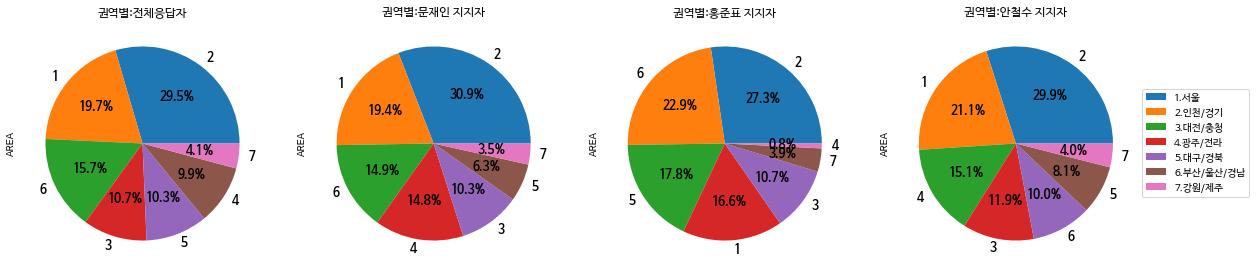

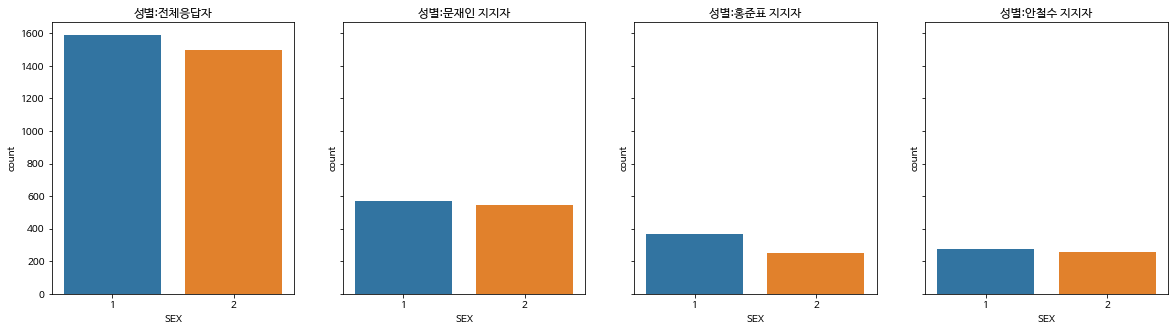

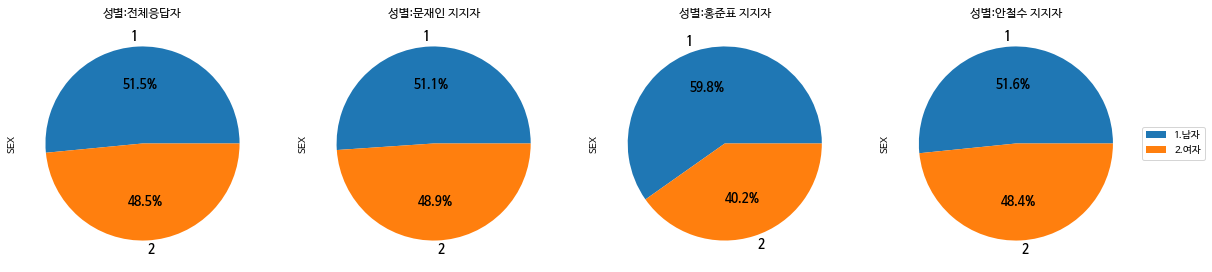

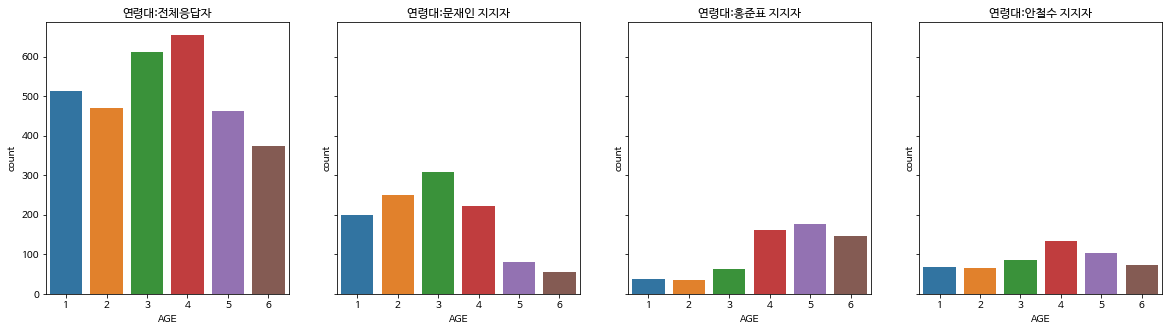

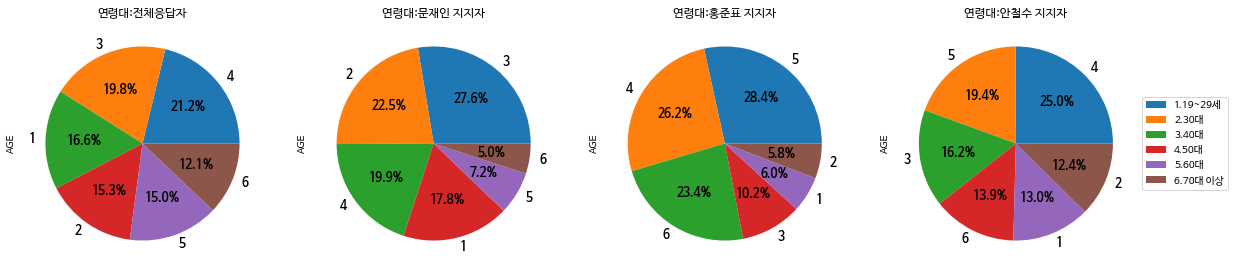

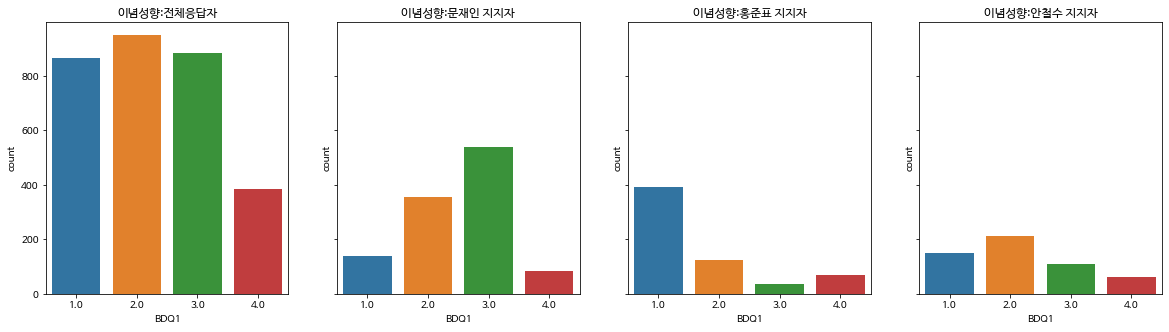

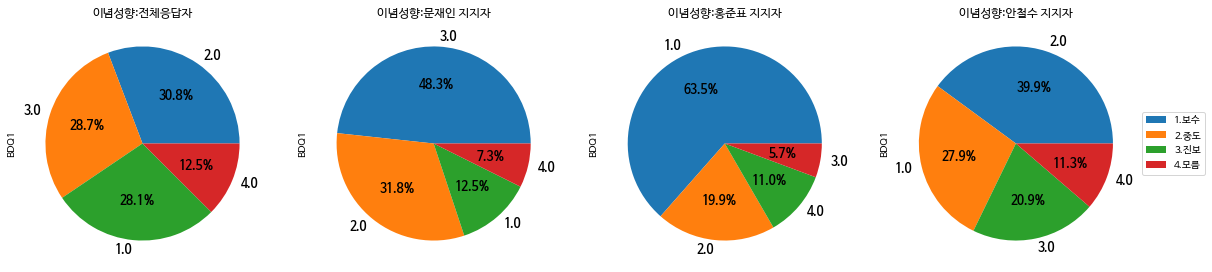

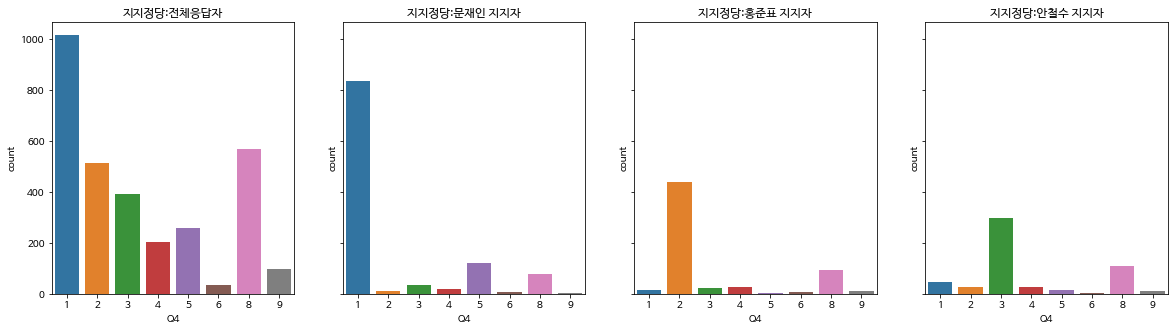

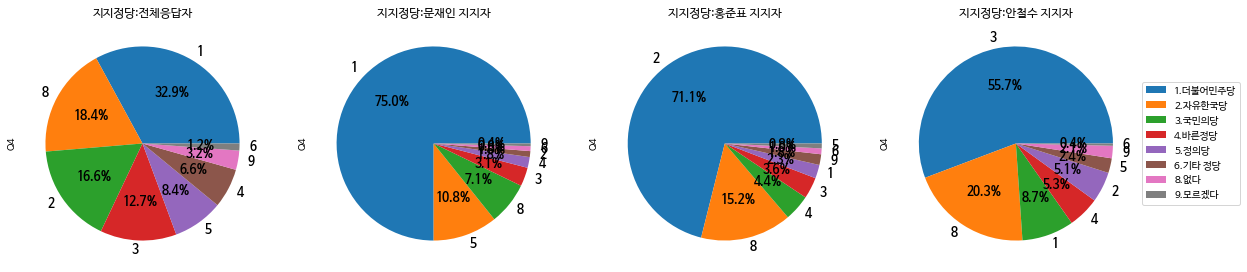

In [ ]:

######################################
## 권역별
f, axes=plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=True)
index=['1.서울','2.인천/경기','3.대전/충청','4.광주/전라','5.대구/경북','6.부산/울산/경남','7.강원/제주']
col=['blue','brown','custom','green','grey','orange','purple','red','silver','white','yellow']
axes[0].set_title('권역별:전체응답자',fontsize=12)
sns.countplot(data=df, x="AREA",ax=axes[0])
axes[1].set_title('권역별:문재인 지지자',fontsize=12)
sns.countplot(data=df_1, x="AREA",ax=axes[1])
axes[2].set_title('권역별:홍준표 지지자',fontsize=12)
sns.countplot(data=df_2, x="AREA", ax=axes[2])
axes[3].set_title('권역별:안철수 지지자',fontsize=12)
sns.countplot(data=df_3, x="AREA", ax=axes[3])
plt.show()

fig,axes=plt.subplots(1,4,figsize=(20,10))
index=['1.서울','2.인천/경기','3.대전/충청','4.광주/전라','5.대구/경북','6.부산/울산/경남','7.강원/제주']
axes[0].set_title('권역별:전체응답자',fontsize=12)
df['AREA'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[0])
axes[1].set_title('권역별:문재인 지지자',fontsize=12)
df_1['AREA'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[1])
axes[2].set_title('권역별:홍준표 지지자',fontsize=12)
df_2['AREA'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[2])
axes[3].set_title('권역별:안철수 지지자',fontsize=12)
df_3['AREA'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[3])
plt.legend(index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


######################################
## 성별
f, axes=plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=True)
index=['1.남자', '2.여자']
col=['blue','brown','custom','green','grey','orange','purple','red','silver','white','yellow']
axes[0].set_title('성별:전체응답자',fontsize=12)
sns.countplot(data=df, x="SEX",ax=axes[0])
axes[1].set_title('성별:문재인 지지자',fontsize=12)
sns.countplot(data=df_1, x="SEX",ax=axes[1])
axes[2].set_title('성별:홍준표 지지자',fontsize=12)
sns.countplot(data=df_2, x="SEX", ax=axes[2])
axes[3].set_title('성별:안철수 지지자',fontsize=12)
sns.countplot(data=df_3, x="SEX", ax=axes[3])
plt.show()

fig,axes=plt.subplots(1,4,figsize=(20,10))
index=['1.남자', '2.여자']
axes[0].set_title('성별:전체응답자',fontsize=12)
df['SEX'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[0])
axes[1].set_title('성별:문재인 지지자',fontsize=12)
df_1['SEX'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[1])
axes[2].set_title('성별:홍준표 지지자',fontsize=12)
df_2['SEX'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[2])
axes[3].set_title('성별:안철수 지지자',fontsize=12)
df_3['SEX'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[3])
plt.legend(index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


######################################
## 연령대
f, axes=plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=True)
index=['1.19~29세', '2.30대', '3.40대', '4.50대', '5.60대', '6.70대 이상']
col=['blue','brown','custom','green','grey','orange','purple','red','silver','white','yellow']
axes[0].set_title('연령대:전체응답자',fontsize=12)
sns.countplot(data=df, x="AGE",ax=axes[0])
axes[1].set_title('연령대:문재인 지지자',fontsize=12)
sns.countplot(data=df_1, x="AGE",ax=axes[1])
axes[2].set_title('연령대:홍준표 지지자',fontsize=12)
sns.countplot(data=df_2, x="AGE", ax=axes[2])
axes[3].set_title('연령대:안철수 지지자',fontsize=12)
sns.countplot(data=df_3, x="AGE", ax=axes[3])
plt.show()

fig,axes=plt.subplots(1,4,figsize=(20,10))
index=['1.19~29세', '2.30대', '3.40대', '4.50대', '5.60대', '6.70대 이상']
axes[0].set_title('연령대:전체응답자',fontsize=12)
df['AGE'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[0])
axes[1].set_title('연령대:문재인 지지자',fontsize=12)
df_1['AGE'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[1])
axes[2].set_title('연령대:홍준표 지지자',fontsize=12)
df_2['AGE'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[2])
axes[3].set_title('연령대:안철수 지지자',fontsize=12)
df_3['AGE'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[3])
plt.legend(index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


######################################
## 이념성향
f, axes=plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=True)
index=['1.보수', '2.중도', '3.진보', '4.모름']
col=['blue','brown','custom','green','grey','orange','purple','red','silver','white','yellow']
axes[0].set_title('이념성향:전체응답자',fontsize=12)
sns.countplot(data=df, x="BDQ1",ax=axes[0])
axes[1].set_title('이념성향:문재인 지지자',fontsize=12)
sns.countplot(data=df_1, x="BDQ1",ax=axes[1])
axes[2].set_title('이념성향:홍준표 지지자',fontsize=12)
sns.countplot(data=df_2, x="BDQ1", ax=axes[2])
axes[3].set_title('이념성향:안철수 지지자',fontsize=12)
sns.countplot(data=df_3, x="BDQ1", ax=axes[3])
plt.show()

fig,axes=plt.subplots(1,4,figsize=(20,10))
index=['1.보수', '2.중도', '3.진보', '4.모름']
axes[0].set_title('이념성향:전체응답자',fontsize=12)
df['BDQ1'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[0])
axes[1].set_title('이념성향:문재인 지지자',fontsize=12)
df_1['BDQ1'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[1])
axes[2].set_title('이념성향:홍준표 지지자',fontsize=12)
df_2['BDQ1'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[2])
axes[3].set_title('이념성향:안철수 지지자',fontsize=12)
df_3['BDQ1'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[3])
plt.legend(index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


######################################
## 지지정당
f, axes=plt.subplots(1, 4, figsize=(20, 5), sharex=False, sharey=True)
index=['1.더불어민주당', '2.자유한국당', '3.국민의당', '4.바른정당', '5.정의당', '6.기타 정당', '8.없다', '9.모르겠다']
col=['blue','brown','custom','green','grey','orange','purple','red','silver','white','yellow']
axes[0].set_title('지지정당:전체응답자',fontsize=12)
sns.countplot(data=df, x="Q4",ax=axes[0])
axes[1].set_title('지지정당:문재인 지지자',fontsize=12)
sns.countplot(data=df_1, x="Q4",ax=axes[1])
axes[2].set_title('지지정당:홍준표 지지자',fontsize=12)
sns.countplot(data=df_2, x="Q4", ax=axes[2])
axes[3].set_title('지지정당:안철수 지지자',fontsize=12)
sns.countplot(data=df_3, x="Q4", ax=axes[3])
plt.show()

fig,axes=plt.subplots(1,4,figsize=(20,10))
index=['1.더불어민주당', '2.자유한국당', '3.국민의당', '4.바른정당', '5.정의당', '6.기타 정당', '8.없다', '9.모르겠다']
axes[0].set_title('지지정당:전체응답자',fontsize=12)
df['Q4'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[0])
axes[1].set_title('지지정당:문재인 지지자',fontsize=12)
df_1['Q4'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[1])
axes[2].set_title('지지정당:홍준표 지지자',fontsize=12)
df_2['Q4'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[2])
axes[3].set_title('지지정당:안철수 지지자',fontsize=12)
df_3['Q4'].value_counts().plot.pie(autopct='%.1f%%', textprops={'fontsize':12, 'weight':'bold'}, ax=axes[3])
plt.legend(index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# => 지지후보별 높은 응답 데이터 정리

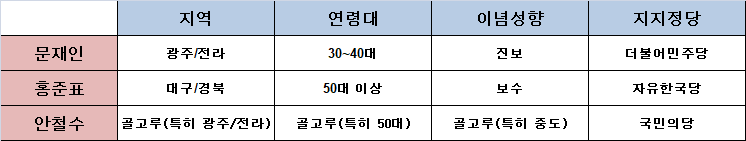

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


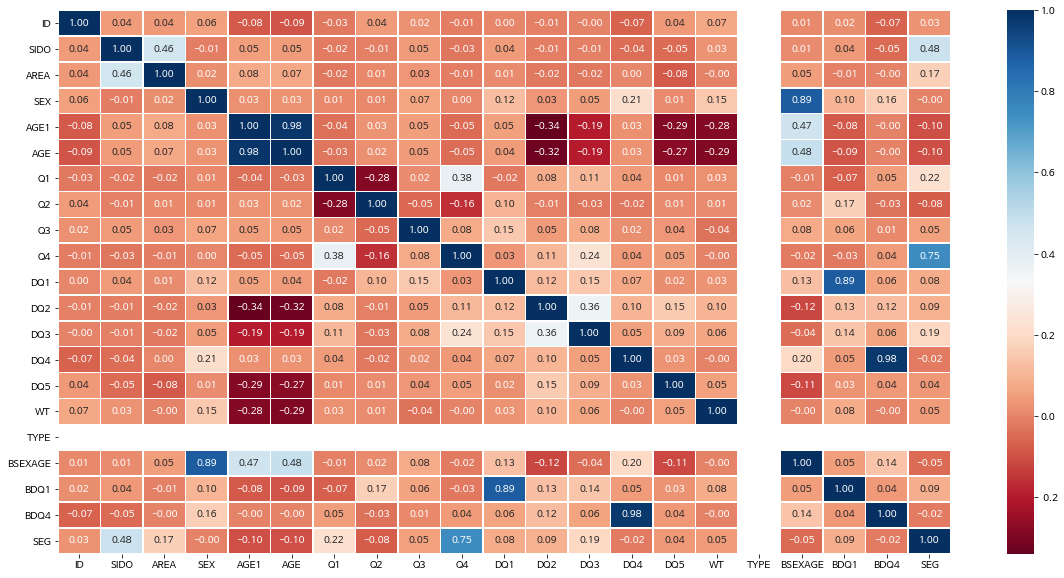

In [ ]:
#######################################################################################
## 상관계수 그래프 => Q2, Q3변수는 TEST 데이터에 응답이 없어서 모델돌릴때 삭제할 예정
#######################################################################################
df11 = df[df.TYPE == 1]

# 전체데이터 기준
corr = df11.corr()
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(corr, annot = True, fmt ='.2f', linewidths=.5, cmap='RdBu')
plt.show()

In [ ]:
#######################################################################################
## 다중공선성 확인
#######################################################################################
df11 = df[df.TYPE == 1]

# 지지후보 응답자 기준
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = df11.columns    
vif['vif'] = [variance_inflation_factor(
             df11.values, i) for i in range(df11.shape[1])]
vif.sort_values(by='vif',ascending=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Features,vif
3,SEX,inf
5,AGE,inf
17,BSEXAGE,inf
4,AGE1,25.622945
13,DQ4,24.142433
19,BDQ4,23.782780
20,SEG,6.117613
18,BDQ1,5.882275
10,DQ1,5.787754
9,Q4,5.153477


In [ ]:
## 다중공선성 재확인 =>  vif가 10이상이면 다중공선성이 존재하는데, SEX, BSEXAGE 2개 독립변수가 다중공선성 문제가 보임
df22 = df11.copy()
df22 = df22.drop(columns = ['TYPE', 'AGE1', 'SEX', 'Q2', 'Q3', 'DQ1', 'DQ4'])

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = df22.columns
vif['vif'] = [variance_inflation_factor(
             df22.values, i) for i in range(df22.shape[1])]
vif.sort_values(by='vif',ascending=False)

,Features,vif
13,SEG,24.803281
5,Q4,13.161521
9,WT,10.448738
1,SIDO,9.419469
12,BDQ4,7.229072
3,AGE,6.858905
11,BDQ1,6.310650
10,BSEXAGE,5.882969
2,AREA,4.943485
4,Q1,4.467434


================================================================================
## XGBoost Hypter Parameter 튜닝
=> https://injo.tistory.com/44?category=1068433

=> https://statkclee.github.io/model/model-python-xgboost-hyper.html

=> https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost

================================================================================


In [ ]:
##################################################
## 데이터 다시 불러와서 모델 실행

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/content/drive/MyDrive/_project/전화조사데이터_WT.xlsx')


##################################################
## 타켓변수가 결측치이면 모델이 돌아가지 않아서 우선 결측치 9로 채움.
df = df.fillna(9)


##################################################
## 성(SEX) & 연령(AGE) 으로 성연령(BSEXAGE) 변수 생성
df.loc[(df.SEX==1) & (df.AGE==1),'BSEXAGE']=1     #1.남-20대
df.loc[(df.SEX==1) & (df.AGE==2),'BSEXAGE']=2     #2.남-30대
df.loc[(df.SEX==1) & (df.AGE==3),'BSEXAGE']=3     #3.남-40대
df.loc[(df.SEX==1) & (df.AGE==4),'BSEXAGE']=4     #4.남-50대
df.loc[(df.SEX==1) & (df.AGE==5),'BSEXAGE']=5     #5.남-60대
df.loc[(df.SEX==1) & (df.AGE==6),'BSEXAGE']=6     #6.남-70대 이상

df.loc[(df.SEX==2) & (df.AGE==1),'BSEXAGE']=7     #7.여-20대
df.loc[(df.SEX==2) & (df.AGE==2),'BSEXAGE']=8     #8.여-30대
df.loc[(df.SEX==2) & (df.AGE==3),'BSEXAGE']=9     #9.여-40대
df.loc[(df.SEX==2) & (df.AGE==4),'BSEXAGE']=10    #10.여-50대
df.loc[(df.SEX==2) & (df.AGE==5),'BSEXAGE']=11    #11.여-60대
df.loc[(df.SEX==2) & (df.AGE==6),'BSEXAGE']=12    #12.여-70대 이상


## DQ1(정치이념성향) 세부적인 분류를 묶어서 변수 생성
df.loc[(df.DQ1==1) | (df.DQ1==2),'BDQ1']=1   #1.보수
df.loc[(df.DQ1==3),'BDQ1']=2                 #2.중도
df.loc[(df.DQ1==4) | (df.DQ1==5),'BDQ1']=3   #3.진보
df.loc[(df.DQ1==9),'BDQ1']=4                 #4.모름


## DQ4(직업) 세부적인 분류를 묶어서 변수 생성
df.loc[(df.DQ4==1),'BDQ4']=1                                   #1.농/임/어업
df.loc[(df.DQ4==2),'BDQ4']=2                                   #2.자영업
df.loc[(df.DQ4==3) | (df.DQ4==4) | (df.DQ4==5),'BDQ4']=3       #3.블루칼라
df.loc[(df.DQ4==6) | (df.DQ4==7) | (df.DQ4==8),'BDQ4']=4       #4.화이트칼라
df.loc[(df.DQ4==9),'BDQ4']=5                                   #5.가정주부
df.loc[(df.DQ4==10),'BDQ4']=6                                  #6.학생
df.loc[(df.DQ4==11) | (df.DQ4==12) | (df.DQ4==13),'BDQ4']=7    #7.무직/은퇴/기타
df.loc[(df.DQ4==99),'BDQ4']=8                                  #8.모름

## 세그먼트 추가변수생성
# segment 1
df.loc[(df.SIDO==1) & (df.Q4==1),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==1),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==1),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==1),'SEG']=1

df.loc[(df.SIDO==1) & (df.Q4==2),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==2),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==2),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==2),'SEG']=1

df.loc[(df.SIDO==1) & (df.Q4==3),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==3),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==3),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==3),'SEG']=1

df.loc[(df.SIDO==1) & (df.Q4==4),'SEG']=1
df.loc[(df.SIDO==2) & (df.Q4==4),'SEG']=1
df.loc[(df.SIDO==3) & (df.Q4==4),'SEG']=1
df.loc[(df.SIDO==4) & (df.Q4==4),'SEG']=1

# segment 2
df.loc[(df.SIDO==5) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==1),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==1),'SEG']=2

df.loc[(df.SIDO==5) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==2),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==2),'SEG']=2

df.loc[(df.SIDO==5) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==3),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==3),'SEG']=2

df.loc[(df.SIDO==5) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==6) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==7) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==8) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==9) & (df.Q4==4),'SEG']=2
df.loc[(df.SIDO==10) & (df.Q4==4),'SEG']=2

# segment 3
df.loc[(df.SIDO==11) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==1),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==1),'SEG']=3

df.loc[(df.SIDO==11) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==2),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==2),'SEG']=3

df.loc[(df.SIDO==11) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==3),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==3),'SEG']=3

df.loc[(df.SIDO==11) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==12) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==13) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==14) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==15) & (df.Q4==4),'SEG']=3
df.loc[(df.SIDO==16) & (df.Q4==4),'SEG']=3

# segment 4
df.loc[(df.SIDO==1) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==5),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==5),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==6),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==6),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==7),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==7),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==8),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==8),'SEG']=4

df.loc[(df.SIDO==1) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==2) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==3) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==4) & (df.Q4==9),'SEG']=4
df.loc[(df.SIDO==5) & (df.Q4==9),'SEG']=4

# segment 5
df.loc[(df.SIDO==6) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==5),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==5),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==6),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==6),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==7),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==7),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==8),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==8),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==8),'SEG']=5

df.loc[(df.SIDO==6) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==7) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==8) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==9) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==10) & (df.Q4==9),'SEG']=5
df.loc[(df.SIDO==11) & (df.Q4==9),'SEG']=5

# segment 6
df.loc[(df.SIDO==12) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==5),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==5),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==6),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==6),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==7),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==7),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==8),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==8),'SEG']=6

df.loc[(df.SIDO==12) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==13) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==14) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==15) & (df.Q4==9),'SEG']=6
df.loc[(df.SIDO==16) & (df.Q4==9),'SEG']=6

##################################################
## 지지후보 응답데이터 : 2757
df1 = df[df.TYPE == 1]
df1 = df1.drop(columns = ['ID', 'Q2', 'Q3', 'TYPE', 'SEX', 'AGE1', 'DQ1', 'DQ4'])  #다중공선성 변수 삭제

## 지지후보 없음/무응답데이터 : 329
df2 = df[df.TYPE == 2]
df2 = df2.drop(columns = ['ID', 'Q2', 'Q3', 'TYPE', 'SEX', 'AGE1', 'DQ1', 'DQ4'])  #다중공선성 변수 삭제

## 예측한 데이터 ID통합용 데이터
df3 = df[df.TYPE == 2]

df1.info()
df2.info()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2757 entries, 0 to 3085
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SIDO     2757 non-null   int64  
 1   AREA     2757 non-null   int64  
 2   AGE      2757 non-null   int64  
 3   Q1       2757 non-null   float64
 4   Q4       2757 non-null   int64  
 5   DQ2      2757 non-null   int64  
 6   DQ3      2757 non-null   int64  
 7   DQ5      2757 non-null   int64  
 8   WT       2757 non-null   float64
 9   BSEXAGE  2757 non-null   float64
 10  BDQ1     2757 non-null   float64
 11  BDQ4     2757 non-null   float64
 12  SEG      2757 non-null   float64
dtypes: float64(6), int64(7)
memory usage: 301.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 3 to 3077
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SIDO     329 non-null    int64  
 1   AREA     329 non-null    int64  
 2   AGE     

In [ ]:
##################################################
## 지지후보 응답데이터로 train, test 나누기

train = df1.drop('Q1', axis = 1)
test = df1['Q1']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.3, random_state =42)


In [ ]:
##################################################
## 하이퍼파라메타 튜닝

from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
print(xgb_clf)


hr_accuracy_list = []

max_depth_list = [3, 4, 5, 6, 7]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1.0]

def hr_grid_search(max_depth, subsample): 
    xgb_model = xgb.XGBClassifier(max_depth=max_depth,
                              subsample=subsample)
    xgb_pred = xgb_model.fit(X_train, y_train).predict(X_test)
    return([max_depth, subsample, accuracy_score(y_test, xgb_pred)])

for max_depth in max_depth_list:
    for subsample in subsample_list:
        hr_accuracy_list.append(hr_grid_search(max_depth, subsample))
    
hr_xgb_df = pd.DataFrame(hr_accuracy_list, columns=['tree depth', 'subsample rate', 'accuracy'])
hr_xgb_df.head() 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


,tree depth,subsample rate,accuracy
0,3,0.6,0.729469
1,3,0.7,0.729469
2,3,0.8,0.723430
3,3,0.9,0.725845
4,3,1.0,0.727053


In [ ]:
## XGBoost 튜닝모형
from xgboost import XGBClassifier
xgb_model = XGBClassifier(base_score=0.5,
                          booster='gbtree',
                          colsample_bylevel=1,
                          colsample_bynode=1,
                          colsample_bytree=1,           # 범위 0~1(크면 과적합 발생)    
                          gamma=0,                      # =>값을 높이면 과적합 제어
                          learning_rate=0.1,
                          max_delta_step=0,
                          max_depth=3,                  # 통상 3~10 적용(크면 과적합 발생)    
                          min_child_weight=1,           # =>값을 높이면 과적합 제어
                          missing=None,
                          n_estimators=100,
                          n_jobs=1,
                          nthread=None,
                          objective='multi:softmax',    # binary:logistic(이진 분류에 사용),  multi:softmax(다중 분류에 사용), multi-softprob(다중 확률에 사용)
                          random_state=0,
                          reg_alpha=0,
                          reg_lambda=1,
                          scale_pos_weight=1,
                          silent=None,
                          subsample=0.7,                # 통상 0.5~1 적용(과적합 제어)
                          verbosity=1,
                          seed=777)

xgb_pred = xgb_model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, xgb_pred))


              precision    recall  f1-score   support

         1.0       0.79      0.88      0.83       363
         2.0       0.77      0.79      0.78       177
         3.0       0.61      0.65      0.63       157
         4.0       0.53      0.38      0.44        63
         5.0       0.43      0.18      0.26        65
         6.0       0.00      0.00      0.00         3

    accuracy                           0.72       828
   macro avg       0.52      0.48      0.49       828
weighted avg       0.70      0.72      0.71       828



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


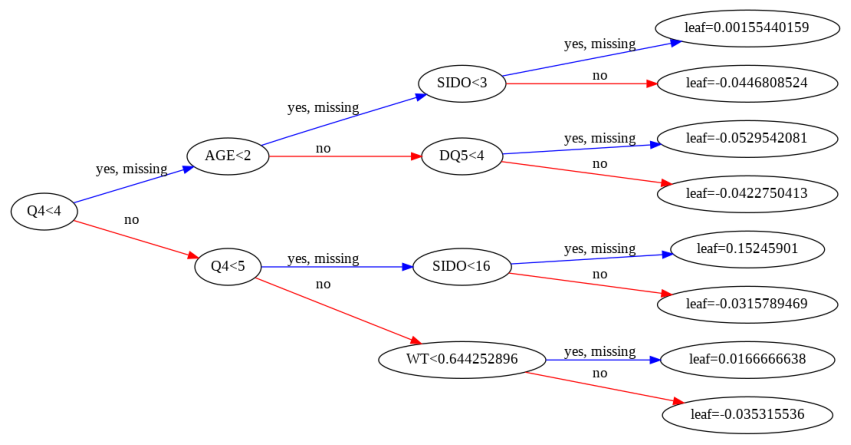

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(xgb_model, num_trees=3, rankdir='LR', ax=ax)

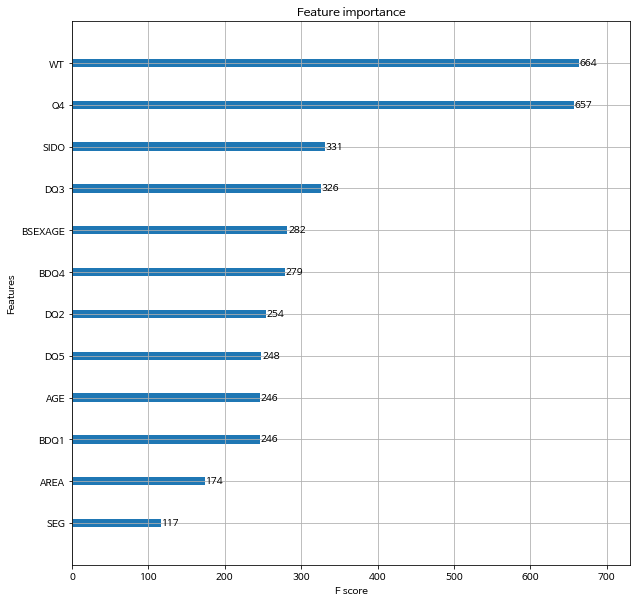

In [ ]:
## XGBoost 모형을 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(xgb_model, ax=ax)

In [ ]:
#######################################################################################
##  현재 xgboost 모델상태로 지지후보 무응답 데이터를 예측해보자
#######################################################################################


X_train = df1.drop('Q1', axis = 1)
X_test = df1['Q1']

y_train = df2.drop('Q1', axis = 1)
y_test = df2['Q1']

xgb_pred = xgb_model.fit(X_train, X_test).predict(y_train)   #원래소스 : xgb_model.fit(X_train, y_train).predict(X_test)
print(xgb_pred)


[4. 2. 2. 2. 2. 3. 1. 5. 2. 1. 1. 5. 5. 2. 3. 3. 2. 2. 1. 2. 3. 5. 3. 3.
 2. 2. 3. 2. 4. 2. 3. 1. 3. 3. 1. 3. 2. 2. 3. 3. 2. 1. 2. 3. 4. 1. 4. 3.
 3. 3. 5. 2. 2. 2. 2. 1. 3. 1. 2. 3. 3. 1. 4. 1. 2. 1. 2. 2. 5. 2. 2. 5.
 3. 2. 5. 5. 2. 5. 3. 3. 1. 3. 1. 4. 2. 1. 2. 3. 5. 3. 2. 3. 1. 3. 2. 3.
 1. 2. 2. 1. 3. 5. 1. 3. 3. 1. 3. 1. 1. 2. 5. 2. 1. 2. 2. 3. 2. 3. 1. 2.
 2. 5. 3. 3. 1. 3. 3. 1. 1. 3. 2. 2. 1. 1. 2. 5. 2. 2. 2. 1. 2. 3. 5. 2.
 2. 1. 1. 3. 3. 3. 2. 2. 3. 1. 3. 3. 5. 3. 2. 2. 5. 5. 1. 3. 3. 5. 5. 2.
 4. 3. 3. 5. 5. 3. 2. 3. 3. 1. 3. 2. 3. 2. 2. 2. 1. 1. 3. 1. 3. 2. 1. 2.
 2. 2. 1. 3. 3. 3. 3. 2. 1. 2. 3. 2. 1. 2. 1. 3. 3. 5. 2. 1. 1. 3. 2. 3.
 1. 4. 2. 1. 2. 2. 2. 4. 2. 4. 1. 3. 5. 3. 1. 3. 2. 3. 5. 4. 2. 3. 5. 5.
 1. 1. 2. 5. 2. 5. 3. 5. 2. 1. 2. 1. 3. 2. 2. 3. 2. 1. 3. 3. 1. 3. 2. 5.
 3. 5. 3. 5. 3. 2. 5. 1. 1. 3. 1. 1. 5. 3. 1. 1. 5. 5. 2. 5. 2. 2. 2. 2.
 3. 3. 2. 3. 3. 3. 3. 3. 3. 1. 2. 4. 3. 2. 1. 3. 1. 1. 2. 1. 5. 3. 2. 5.
 3. 5. 4. 3. 2. 3. 2. 2. 3. 5. 3. 1. 2. 3. 5. 3. 2.

In [ ]:
## ID와 Q1 예측값 결합해서 데이터 생성

submission = {'ID':df3['ID'], 'Q1':xgb_pred}
submission = pd.DataFrame(submission)
submission.info()
submission.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 3 to 3077
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      329 non-null    int64  
 1   Q1      329 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.7 KB


,ID,Q1
3,4,4.0
14,15,2.0
15,16,2.0
16,17,2.0
29,30,2.0
41,42,3.0
48,49,1.0
66,67,5.0
67,68,2.0
71,72,1.0


In [ ]:
## Q1 예측값 엑셀파일 저장

submission.to_excel('/content/drive/MyDrive/_project/submission.xlsx')